In [1]:
!pip install transformers[torch]==4.38.0 datasets pandas scikit-learn tabulate accelerate==0.27.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 893.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.3 MB/s eta 0:00:00
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.7 MB/s eta 0:00:00
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 10.7 MB/s eta 0:00:00
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB

In [1]:
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 798.8 kB/s eta 0:00:000:00:01


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ivanmitriakhin/arxiv-titles-abstracts-and-tags")
path2 = kagglehub.dataset_download("spsayakpaul/arxiv-paper-abstracts")


print("Path to dataset files:", path)
print("Path to dataset files:", path2)

/mnt/c/Users/Raymond/Desktop/SCIBERT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 860M/860M [00:33<00:00, 27.2MB/s] 

Extracting files...


100%|██████████| 44.6M/44.6M [00:02<00:00, 15.6MB/s]

Extracting files...


Path to dataset files: /home/raymond/.cache/kagglehub/datasets/ivanmitriakhin/arxiv-titles-abstracts-and-tags/versions/5
Path to dataset files: /home/raymond/.cache/kagglehub/datasets/spsayakpaul/arxiv-paper-abstracts/versions/2


In [1]:
import pandas as pd
import torch
from datasets import Dataset
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import re
import transformers
import accelerate

/mnt/c/Users/User/Desktop/bert/12venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# --- 1. Configuration ---
file_path = 'arxiv_data_grouped.csv'
title_column = 'titles'
abstract_column = 'abstracts'
MODEL_CHECKPOINT = 'allenai/scibert_scivocab_uncased'
output_model_dir = './fine-tuned-scibert-multilabel'

In [5]:
# --- 2. Data Loading and Cleaning ---
print(f"Loading data from: {file_path}")
df = pd.read_csv(file_path)

def clean_text(text):
    if not isinstance(text, str): 
        return ""
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

print("Cleaning text data...")
df[title_column] = df[title_column].apply(clean_text)
df[abstract_column] = df[abstract_column].apply(clean_text)

Loading data from: arxiv_data_grouped.csv
Cleaning text data...


In [6]:
# --- 3. Data Preprocessing ---
first_label_index = df.columns.get_loc(abstract_column) + 1
label_columns = df.columns[first_label_index:].tolist()
df['text'] = df[title_column] + " [SEP] " + df[abstract_column]

# Convert labels to float32 numpy arrays (this ensures proper dtype)
df['labels'] = df[label_columns].values.astype(np.float32).tolist()
df_clean = df[['text', 'labels']]

print(f"Dataset shape: {df_clean.shape}")
print(f"Number of label classes: {len(label_columns)}")
print(f"Sample labels: {df_clean['labels'].iloc[0]}")

Dataset shape: (536914, 2)
Number of label classes: 8
Sample labels: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [7]:
# --- 4. Tokenization ---
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)


Loading tokenizer...


/mnt/c/Users/User/Desktop/bert/12venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
# --- 5. Dataset Creation and Processing ---
print("Creating dataset...")
full_dataset = Dataset.from_pandas(df_clean)

print("Tokenizing dataset...")
tokenized_dataset = full_dataset.map(tokenize_function, batched=True)

# Remove text column (no longer needed)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])

# Set format to torch tensors (this handles the float32 conversion automatically)
print("Setting dataset format to PyTorch tensors...")
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Verify the conversion worked
sample = tokenized_dataset[0]
print(f"Labels type: {type(sample['labels'])}")
print(f"Labels dtype: {sample['labels'].dtype}")
print(f"Sample labels: {sample['labels']}")

Creating dataset...
Tokenizing dataset...


Map: 100%|██████████| 536914/536914 [01:43<00:00, 5191.62 examples/s] 

Setting dataset format to PyTorch tensors...
Labels type: <class 'torch.Tensor'>
Labels dtype: torch.float32
Sample labels: tensor([1., 0., 0., 0., 0., 0., 0., 1.])


In [9]:
# --- 6. Train/Test Split ---
print("Splitting dataset...")
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(eval_dataset)}")

Splitting dataset...
Train dataset size: 429531
Eval dataset size: 107383


In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer

model = AutoModelForSequenceClassification.from_pretrained("fine-tuned-scibert-multilabel")
tokenizer = AutoTokenizer.from_pretrained("fine-tuned-scibert-multilabel")

# trainer = Trainer(model=model, tokenizer=tokenizer)  # <-- no compute_metrics here
# results = trainer.evaluate(eval_dataset)
# print(results)


In [15]:
def compute_metrics(eval_pred):
    import numpy as np
    import torch
    from sklearn.metrics import f1_score, accuracy_score, hamming_loss

    logits, labels = eval_pred
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(logits))
    # Use a 0.5 threshold to get binary predictions
    preds = (probs >= 0.5).int().numpy()

    # Calculate the core metrics
    f1_micro = f1_score(labels, preds, average="micro")
    f1_macro = f1_score(labels, preds, average="macro")
    accuracy_exact_match = accuracy_score(labels, preds)
    h_loss = hamming_loss(labels, preds)

    # This will be used for your bar chart figure
    label_columns = [
        'Computer Science', 'Economics', 'Electrical Engineering and Systems Science',
        'Mathematics', 'Physics', 'Quantitative Biology', 'Quantitative Finance', 'Statistics'
    ]
    per_category_f1 = f1_score(labels, preds, average=None)
    
    # Create a dictionary for the per-category scores
    per_category_metrics = {f"f1_{label.replace(' ', '_')}": score for label, score in zip(label_columns, per_category_f1)}

    # Combine all metrics into one dictionary
    all_metrics = {
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "accuracy_exact_match": accuracy_exact_match,
        "hamming_loss": h_loss,
    }
    all_metrics.update(per_category_metrics)
    
    return all_metrics

from transformers import Trainer

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,   # <-- reattach
)

results = trainer.evaluate()
print(results)


{'eval_loss': 0.09524441510438919, 'eval_f1_micro': 0.8885201809385752, 'eval_f1_macro': 0.818893991603447, 'eval_accuracy_exact_match': 0.7693489658512055, 'eval_hamming_loss': 0.03715089911810994, 'eval_f1_Computer_Science': 0.9138377834792363, 'eval_f1_Economics': 0.7090813093980992, 'eval_f1_Electrical_Engineering_and_Systems_Science': 0.7035295992351207, 'eval_f1_Mathematics': 0.8901263903669256, 'eval_f1_Physics': 0.9376317037919659, 'eval_f1_Quantitative_Biology': 0.8196665532494045, 'eval_f1_Quantitative_Finance': 0.8595590456055572, 'eval_f1_Statistics': 0.7177195477012661, 'eval_runtime': 1747.9887, 'eval_samples_per_second': 61.432, 'eval_steps_per_second': 7.679}


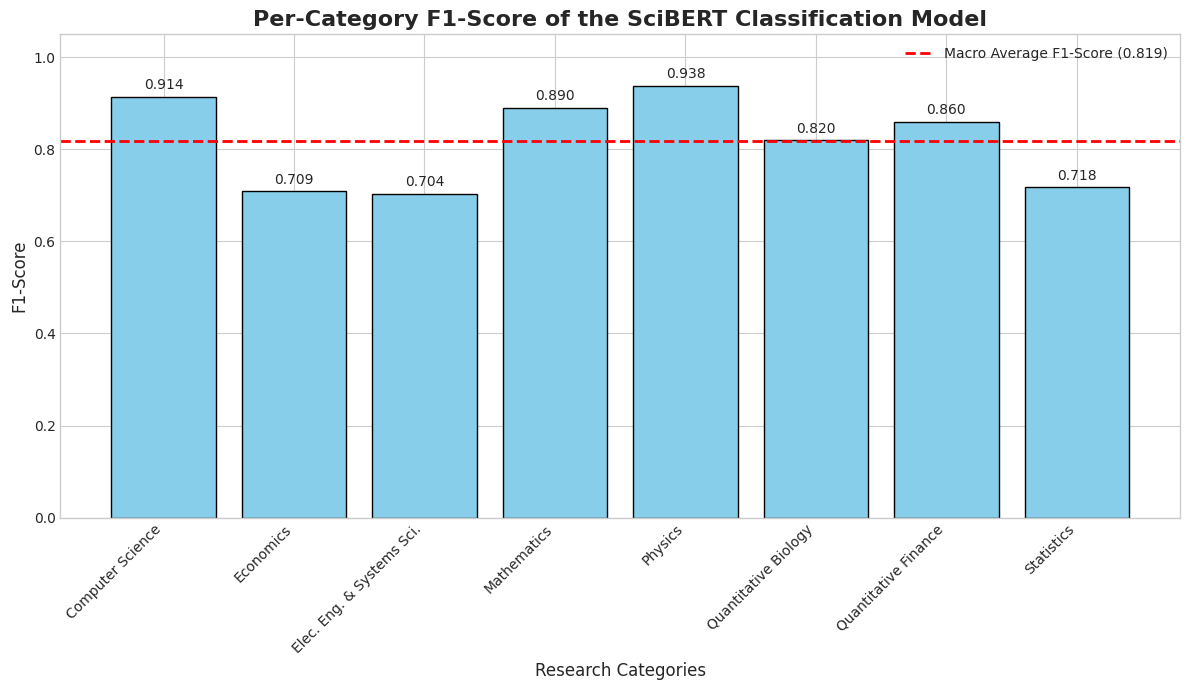

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Manually enter the results from your evaluation output ---
# This ensures the plot is based on your successful model run.

# The names of your categories (for the x-axis labels)
# I've shortened one for better display on the chart
categories = [
    'Computer Science', 'Economics', 'Elec. Eng. & Systems Sci.',
    'Mathematics', 'Physics', 'Quantitative Biology', 'Quantitative Finance', 'Statistics'
]

# The F1-scores for each of those categories from your results
f1_scores = [
    0.9138,  # Computer Science
    0.7090,  # Economics
    0.7035,  # Electrical Engineering...
    0.8901,  # Mathematics
    0.9376,  # Physics
    0.8196,  # Quantitative Biology
    0.8595,  # Quantitative Finance
    0.7177   # Statistics
]

# The macro-average F1-score from your results
f1_macro_average = 0.8188

# --- 2. Create the Bar Chart ---

# Set up the plot style for a professional look
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Create the bars
bars = ax.bar(categories, f1_scores, color='skyblue', edgecolor='black')

# Add a horizontal line for the macro-average F1-score
ax.axhline(y=f1_macro_average, color='r', linestyle='--', linewidth=2, label=f'Macro Average F1-Score ({f1_macro_average:.3f})')

# --- 3. Formatting and Labels ---

# Set the title and axis labels
ax.set_title('Per-Category F1-Score of the SciBERT Classification Model', fontsize=16, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_xlabel('Research Categories', fontsize=12)

# Rotate the x-axis labels to prevent them from overlapping
plt.xticks(rotation=45, ha='right')

# Set the y-axis limits to give some space at the top
ax.set_ylim(0, 1.05)

# Add the value label on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

# Add a legend
ax.legend()

# Ensure everything fits nicely
plt.tight_layout()

# --- 4. Save the Figure ---
# This will save the plot as a high-quality PNG file in your notebook's directory.
# You can then download this file and insert it into your paper.
plt.savefig('per_category_f1_scores.png', dpi=300)

# Display the plot in the notebook
plt.show()